In [199]:
import astroprov
from astropy.io import fits
from astropy.io.ascii import SExtractor
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import os
from photutils import DAOStarFinder
from photutils import CircularAperture
from photutils import aperture_photometry
#import subproc

import numpy as np
from astropy import wcs
from astropy.io import fits
import sys

from astroquery.simbad import Simbad

import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.table import Table, vstack
from astropy.table import Column

import collections
import subprocess
from astropy.io import ascii
import time
from astropy.utils.data import clear_download_cache
from astroquery.gaia import Gaia
from matplotlib.colors import LogNorm
import matplotlib.image as mpimg

In [52]:
sexDir = '/home/mj1e16/sextractor/sextractor-master/config/'
catName = 'test_test.cat'
confName = 'default_test.sex'
imDir = '/data/mj1e16/kepler/cal/'
simDir = '/home/mj1e16/Simages/'

In [14]:
def load_wcs_from_file(filename,pixCoord,ccd=0):
    # Load the FITS hdulist using astropy.io.fits
    hdulist = fits.open(filename)

    # Parse the WCS keywords in the primary HDU
    w = wcs.WCS(hdulist[ccd].header)

    # Print out the "name" of the WCS, as defined in the FITS header
    #print(w.wcs.name)

    # Print out all of the settings that were parsed from the header
    w.wcs.print_contents()

    # Three pixel coordinates of interest.
    # Note we've silently assumed a NAXIS=2 image here.
    # Note also that the pixel coordinates are pairs of [X, Y], 
    # and since WCS built from FITS header automatically has
    # origin set to 1, [0, 0] is actually not inside the image.
    pixcrd = np.array(pixCoord, dtype=np.float_)

    # Convert pixel coordinates to world coordinates
    # The second argument is "origin" -- in this case we're declaring we
    # have 1-based (Fortran-like) coordinates.
    world = w.wcs_pix2world(pixcrd, 1)
    #print(world)
    return(world)

In [146]:
def sextractor(sextractoryDir,imagename,cataloguename,imageDir='/home/mj1e16/keplerImages/',ccd=0):
    
    os.chdir(sextractoryDir)
    subprocess.call(['sex',imageDir+imagename+'[{}]'.format(ccd),'-c',confName])
    tab = Table.read(cataloguename,format='ascii.sextractor')
    
    if len(tab) != 0:
        pan = tab.to_pandas()
        pan = pan[pan['MAG_BEST'] != 99.0]
#         pan = pan[pan['ELLIPTICITY'] < np.median(pan['ELLIPTICITY'])]
#         pan = pan[pan['ELONGATION'] < np.median(pan['ELONGATION'])]
        tab = Table.from_pandas(pan)
        xpos = tab['X_IMAGE']
        ypos = tab['Y_IMAGE']
        coords = [[x,y] for x,y in zip(xpos,ypos)]
        imageCoords = load_wcs_from_file(imageDir+imagename,coords,ccd=ccd)
        ra = [x[0] for x in imageCoords]
        dec = [x[1] for x in imageCoords]
        tab['RA'] = ra
        tab['DEC'] = dec
        imNames = [imagename]*len(ra)
        tab['IMAGE_NAME'] = imNames
    
    return tab

In [38]:
def gaiaSearch(table):
    RA = table['RA']
    DEC = table['DEC']
    width = u.Quantity(5., u.arcsecond)
    height = u.Quantity(5., u.arcsecond)
    #coord = [str(RA[0])+','+str(DEC[0])]
    t0 = time.time()
    match = []
    for x in range(len(RA)):
        coord = SkyCoord(ra=RA[x], dec=DEC[x], unit=(u.degree, u.degree), frame='icrs')
        if x ==0:
            result_table = Gaia.query_object_async(coordinate=coord, width=width, height=height)
        else:
            newtab = Gaia.query_object_async(coordinate=coord, width=width, height=height)
            if len(newtab) != 0:
                result_table.add_row(newtab[0])
                match.append(x)
    print(time.time() - t0)
    return [result_table,match]

In [147]:
result_tab = sextractor(sexDir,'kplr2010078174524_ffi-cal.fits',catName,imageDir=imDir,ccd=25)

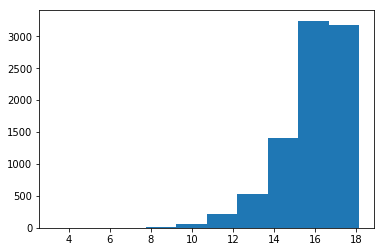

In [143]:
mags = result_tab['MAG_BEST']
mags = [x for x in mags if x < 99]
plt.hist(mags)
plt.show()

In [148]:
gaiares = gaiaSearch(result_tab[0:1000])
gaiaTab = gaiares[0]
match = gaiares[1]

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

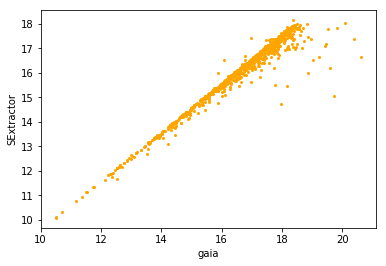

In [153]:
gaiaMag = gaiaTab['phot_g_mean_mag']
sexMag = result_tab['MAG_BEST']
sexMag = [i for x,i in enumerate(sexMag) if x in match]
plt.plot(gaiaMag,sexMag,'o',markersize=2,color='orange')
# for x in range(11,18):
#     plt.plot([10,18],[x,x],color='blue')
#     plt.plot([x,x],[10,18],color='blue')
plt.xlabel('gaia')
plt.ylabel('SExtractor')
plt.savefig('/home/mj1e16/thesisFigures/SExtractorMagConv.png')
plt.show()

In [49]:
magdiff = [x-y for x,y in zip(gaiaMag,sexMag)]

In [141]:
result_tab

NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,MAGERR_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY
,ct,ct,mag,mag,pix,pix,
int64,float64,float64,float64,float64,float64,float64,float64
1,450112.3,71.76128,10.8667,0.0002,324.8007,93.5514,0.36
2,360064.9,10.62873,11.109,0.0,984.9065,18.1292,0.252
3,365084.5,10.62873,11.094,0.0,889.9064,17.7053,0.221
4,360064.5,10.62873,11.109,0.0,713.9378,18.2619,0.326
5,365117.9,10.62873,11.0939,0.0,618.9378,17.7157,0.322
6,360021.8,10.8312,11.1092,0.0,442.5738,18.1879,0.066
7,365086.8,10.8312,11.094,0.0,347.5738,17.7735,0.035
8,360033.6,11.22519,11.1091,0.0,171.6442,18.3444,0.103


In [51]:
print(np.median(magdiff))

0.4872649658203123


In [109]:
for x in range(1,8):
    
    xax = (x-1)%3
    yax = (x-1)/3
    print(xax,yax)

(0, 0)
(1, 0)
(2, 0)
(0, 1)
(1, 1)
(2, 1)
(0, 2)


(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)


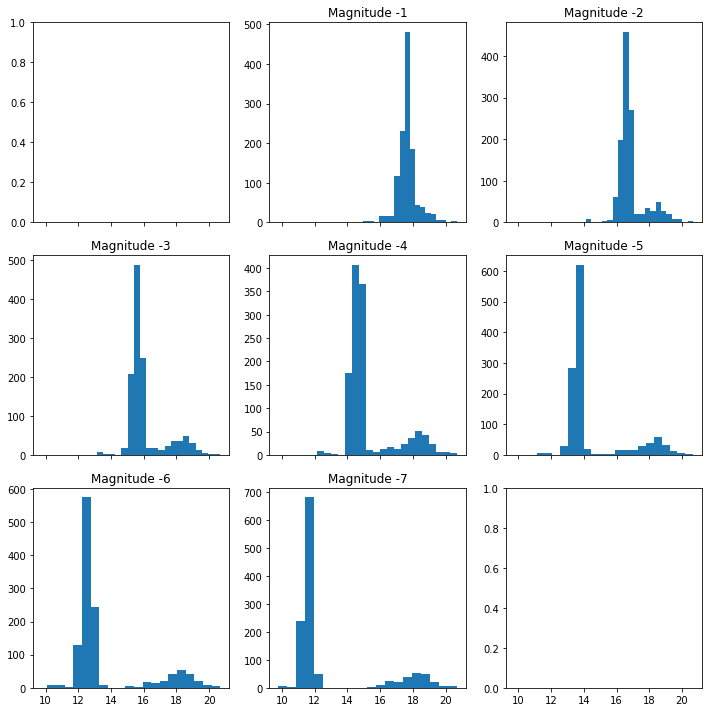

In [127]:
# axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7]
fig, axes = plt.subplots(3,3,sharex=True,figsize=(10,10))
magrange = [1,2,3,4,5,6,7]
medianMags = []
for mag in magrange:
    result_tab = sextractor(sexDir,'diff_44_1-{}_alt.fits'.format(mag),catName,imageDir=simDir,ccd=0)
    magnitudes = result_tab['MAG_BEST']
    magnitudes = [x for x in magnitudes if x < 99]
    medianMags.append(np.median(magnitudes))
    
    x = mag/3
    y = mag%3
    print(x,y)
    axes[x,y].hist(magnitudes,20)
    axes[x,y].title.set_text('Magnitude -{}'.format(mag))
plt.tight_layout()
plt.savefig('/home/mj1e16/thesisFigures/simulatedHistograms.png')
plt.show()


In [115]:
print(ax)

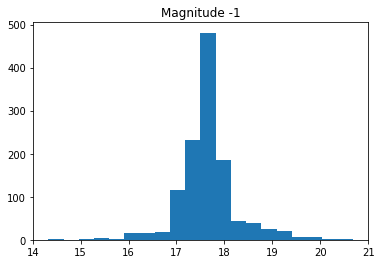

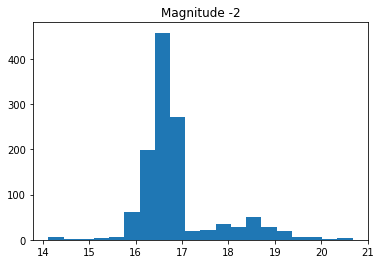

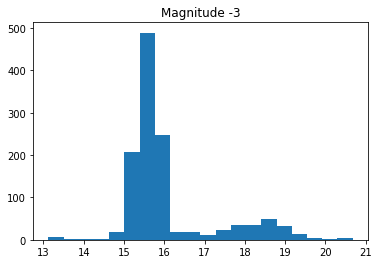

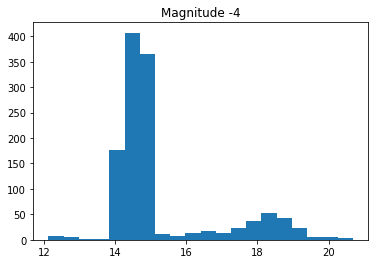

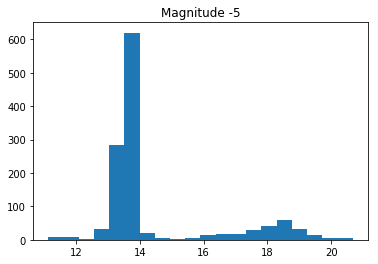

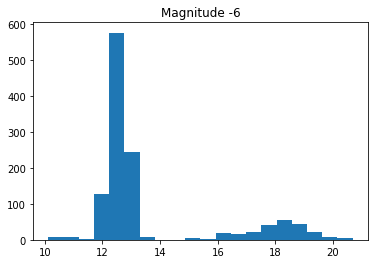

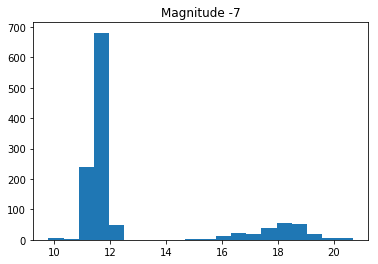

In [100]:
medianMags = []
for mag in range(1,8):
    result_tab = sextractor(sexDir,'diff_44_1-{}_alt.fits'.format(mag),catName,imageDir=simDir,ccd=0)
    magnitudes = result_tab['MAG_BEST']
    magnitudes = [x for x in magnitudes if x < 99]
    medianMags.append(np.median(magnitudes))
    plt.hist(magnitudes,20)
    plt.title('Magnitude -{}'.format(mag))
    plt.show()

In [68]:
magnitudes = result_tab['MAG_BEST']
magnitudes = [x for x in magnitudes if x < 99]

In [106]:
medianMags

[17.6423, 16.6704, 15.6909, 14.69275, 13.69045, 12.6891, 11.68895]

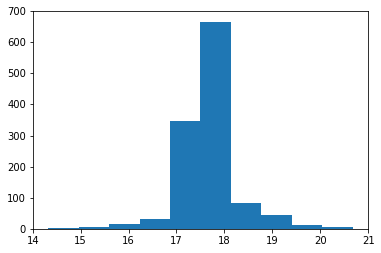

In [70]:
plt.hist(magnitudes)
plt.show()

In [76]:
firsthalf = ascii.read('/home/mj1e16/outTablesImproved/final/firsthalf.csv')
secondhalf = ascii.read('/home/mj1e16/outTablesImproved/final/secondhalf.csv')
transients = vstack([firsthalf,secondhalf])

In [150]:
mags = transients['MAG_BEST']
mags = [x for x in mags if x < 99]
plt.hist(mags,500)
plt.savefig('~/thesisFigures/magdistofTransients.png')
plt.show()

IOError: [Errno 2] No such file or directory: '~/thesisFigures/magdistofTransients.png'

In [79]:
np.mean(mags)

17.93903893254463

In [103]:
def diffImaHist(image):
    hdu_list = fits.open(image)
    image_data = hdu_list[0].data
    plt.hist(image_data.flatten(),10000)
    plt.xlim([-50,50])
    plt.show()

In [104]:
images = ['/home/mj1e16/Simages/diff_44_1.fits','/home/mj1e16/Simages/diff_63_1.fits','/home/mj1e16/Simages/diff_79_1.fits']

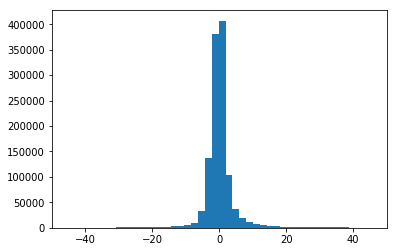

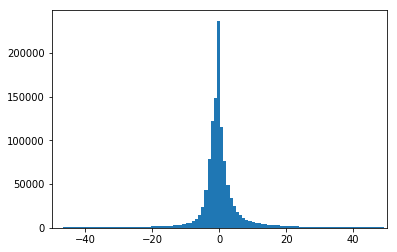

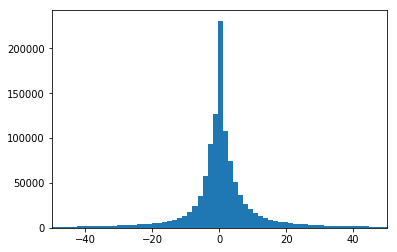

In [105]:
for im in images:
    diffImaHist(im)

In [159]:
fullimages = '/data/mj1e16/kepler/cal/kplr2013038133130_ffi-cal.fits'
ccds = [44,63,79]

In [158]:
hdu_list = fits.open('/data/mj1e16/kepler/cal/kplr2013038133130_ffi-cal.fits')

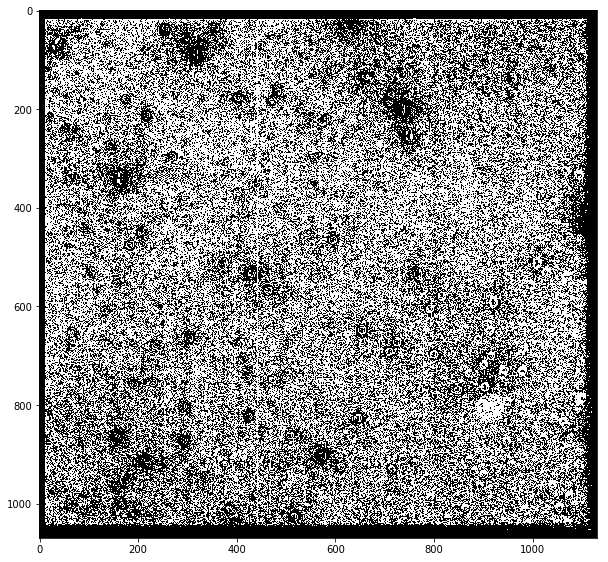

In [196]:
hdu_list = fits.open(images[0])
image_data = hdu_list[0].data 
plt.figure(figsize=(10,10))
plt.imshow(image_data,norm=LogNorm(),cmap='gray',vmin=10**5,vmax=10**6)
plt.show()

In [200]:
images = ['/home/mj1e16/Simages/44real.png','/home/mj1e16/Simages/63real.png','/home/mj1e16/Simages/79real.png']
diffimages = ['/home/mj1e16/Simages/diff44.png','/home/mj1e16/Simages/diff63.png','/home/mj1e16/Simages/diff79.png']
fitsimages = ['/home/mj1e16/Simages/diff_44_1.fits','/home/mj1e16/Simages/diff_63_1.fits','/home/mj1e16/Simages/diff_79_1.fits']

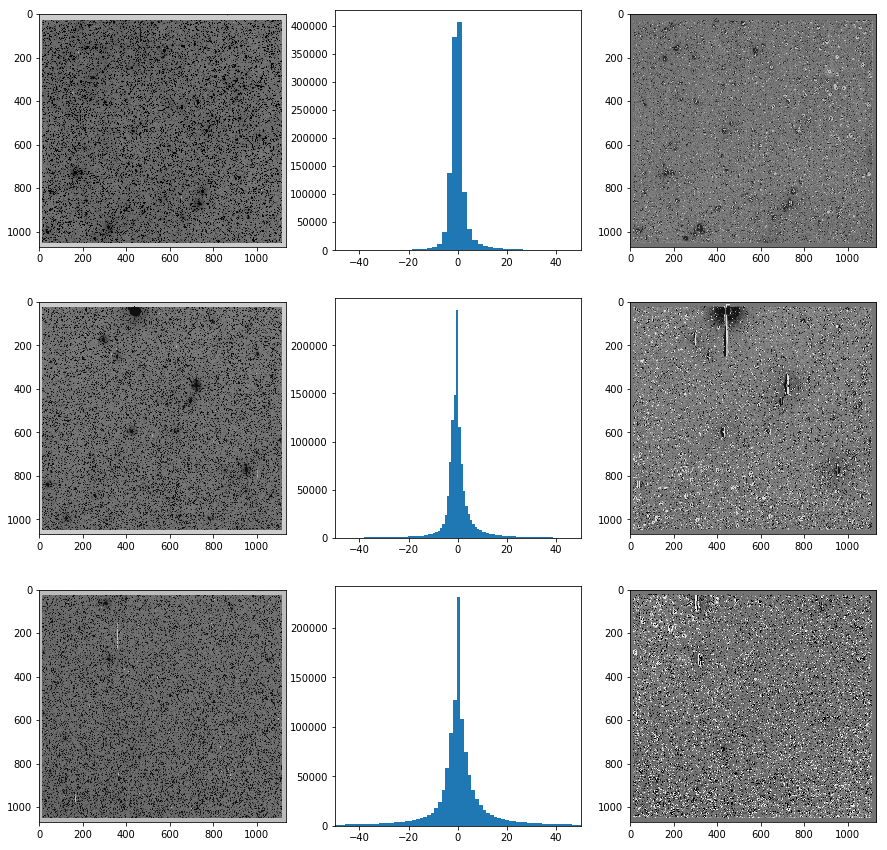

In [201]:
fig,axes = plt.subplots(3,3,figsize=(15,15))

for im in range(len(images)):
    
    img = mpimg.imread(images[im])
    axes[im,0].imshow(img)
    
    hdu_list = fits.open(fitsimages[im])
    image_data = hdu_list[0].data 
    
    axes[im,1].hist(image_data.flatten(),10000)
    axes[im,1].set_xlim([-50,50])
    
    img2 = mpimg.imread(diffimages[im])
    axes[im,2].imshow(img2)
    
plt.savefig('/home/mj1e16/thesisFigures/diffImHist.png')
plt.show()

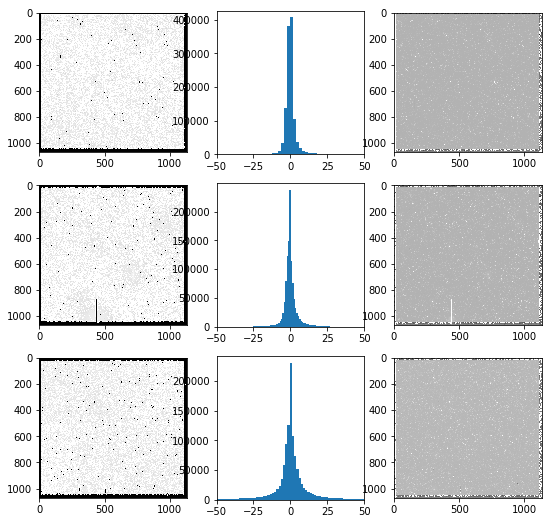

In [163]:
fig,axes = plt.subplots(3,3,figsize=(9,9))

for im in range(len(images)):
    

    
    hdu_list = fits.open(images[im])
    image_data = hdu_list[0].data 
    
    axes[im,0].imshow(image_data,cmap='gray',norm=LogNorm())
    
    axes[im,1].hist(image_data.flatten(),10000)
    axes[im,1].set_xlim([-50,50])
    
    hdu_list_2 = fits.open(fullimages)
    image_data_2 = hdu_list_2[ccds[im]].data
    
    axes[im,2].imshow(image_data_2,cmap='gray',norm=LogNorm())
    
plt.savefig('/home/mj1e16/thesisFigures/diffImHist.png')
plt.show()

In [131]:
plt.savefig('/home/mj1e16/thesisFigures/diffImHist.png')

In [88]:
hdu_list = fits.open('/home/mj1e16/Simages/diff_44_1.fits')
image_data = hdu_list[0].data

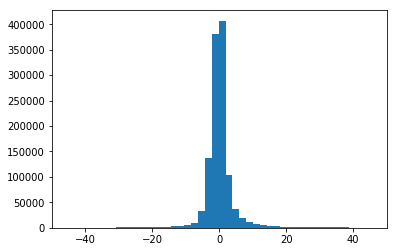

In [102]:
plt.hist(image_data.flatten(),10000)
plt.xlim([-50,50])
plt.show()

In [90]:
np.median(image_data.flatten())

-0.13851929